In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/M1_S2/RITAL/projet2
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install python-terrier
import pandas as pd

import pyterrier as pt
if not pt.started():
  pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:
def plot_smooth(y,T=None,log=False,title="",color=None) :
    if T!=None :
        c=[]


        for i in range(T,len(y)-T) :
            c.append(np.sum(y[i-T:i+T])/(2*T))

        plt.plot(range(T,len(c)+T),c,label=title,color=color)
    else : 
        plt.plot(range(len(y)),y,label=title,color=color)
    
    if log :
        plt.xscale('log')

In [3]:
def string_to_list (s):
    """
    Converti un string de liste en une liste d'entier
    ex "21,22"->[21,22]
    """
    l=[]
    for i in s.split(',') :
        l.append(int(i))
    return l

# 1 - Chargement des fichiers

### 1a) Chargement documents

On charge le json dans un fichier pyterrier index

In [4]:
# chargement du json en dataframe
with open('WikiPassageQA/document_passages.json', 'r') as f:
        data_row = json.load(f)
data={"DocumentID" : [int(k0) for k0,v0 in data_row.items() for k1,v1 in v0.items()],
    "docno" : [k0+','+k1 for k0,v0 in data_row.items() for k1,v1 in v0.items()],
      "text"  : [v1 for k0,v0 in data_row.items() for k1,v1 in v0.items()]}
docs_df = pd.DataFrame(data)

In [5]:
import json
pt_index_path = './passageQA'
if not os.path.exists(pt_index_path + "/data.properties") :
    # création de l'index
    #indexer = pt.DFIndexer(pt_index_path, overwrite=True)
    indexer = pt.DFIndexer(pt_index_path, overwrite=True,stemmer=None, stopwords=None, tokeniser=None)
    index_ref = indexer.index(docs_df["text"], docs_df["docno"])

else:
    # dans le cas où l'index existe déjà
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
index = pt.IndexFactory.of(index_ref)

In [6]:
print(index.getCollectionStatistics().toString())

Number of documents: 50612
Number of terms: 103283
Number of postings: 3056988
Number of fields: 0
Number of tokens: 3906884
Field names: []
Positions:   false



### 1b) Chargement queries

In [7]:
df_train = pd.read_csv("WikiPassageQA/train.tsv",sep='\t')
df_test = pd.read_csv("WikiPassageQA/test.tsv",sep='\t')
df_dev = pd.read_csv("WikiPassageQA/dev.tsv",sep='\t')

In [8]:
queries_train=df_train[["QID", "Question"]]
queries_train.columns = ['qid', 'query']
queries_test=df_test[["QID", "Question"]]
queries_test.columns = ['qid', 'query']
queries_dev=df_dev[["QID", "Question"]]
queries_dev.columns = ['qid', 'query']

queries_test

,qid,query
0,449,What is Iraq's role in political unstabilization?
1,1140,What have been the warmest years of global war...
2,782,How were the Olympic games broadcasted?
3,1421,What was the election turnout for 2008?
4,3738,How has secularism been misinterpreted in Amer...
...,...,...
411,2522,What does the Church mean by Fallen Nature?
412,2851,What is the history of Eurasia?
413,3705,What are the nicknames of Missouri?
414,799,How do endoglossic and exoglossic languages co...


### 1c) Création qrels

In [9]:
df_query = pd.concat([df_train, df_test, df_dev])
df_complete = df_query.merge(docs_df, on =["DocumentID"])
df_complete

,QID,Question,DocumentID,DocumentName,RelevantPassages,docno,text
0,3086,What is the role of conversionism in Evangelic...,672,Evangelicalism.html,4,"672,42",They claimed major credit for the election of ...
1,3086,What is the role of conversionism in Evangelic...,672,Evangelicalism.html,4,"672,48",Evangelicalism was a major force in the Anglic...
2,3086,What is the role of conversionism in Evangelic...,672,Evangelicalism.html,4,"672,43",The rich and the poor remained traditional Cat...
3,3086,What is the role of conversionism in Evangelic...,672,Evangelicalism.html,4,"672,49","The Evangelical Alliance, formed in 1846, was ..."
4,3086,What is the role of conversionism in Evangelic...,672,Evangelicalism.html,4,"672,24","By 1737, Whitefield had become a national cele..."
...,...,...,...,...,...,...,...
244131,2570,How was the kalmar Union formed?,553,Norway.html,"18,19,20,21","553,72",The budgetary rule is to spend no more than 4%...
244132,2570,How was the kalmar Union formed?,553,Norway.html,"18,19,20,21","553,71",Norway is the fifth-largest oil exporter and t...
244133,2570,How was the kalmar Union formed?,553,Norway.html,"18,19,20,21","553,70","In 2011, 28% of state revenues were generated ..."
244134,2570,How was the kalmar Union formed?,553,Norway.html,"18,19,20,21","553,79",The two most prominent are the E6 going north-...


In [10]:
# cree list relevant
relevant = []
for row in df_complete.iterrows():
  passage = row[1]['RelevantPassages'].split(",")
  doc_passage = row[1]['docno'].split(",")[1] # doc,pass -> [1]
  if doc_passage in passage:
    relevant.append(1)
  else:
    relevant.append(0)

df_complete["label"] = relevant
qrel = df_complete[["QID", "docno","label"]]
qrel.columns = ['qid', 'docno', 'label']
qrel = qrel.astype({"qid": str, "docno": object, "label":object}) #qid en string pour pt.Experiment
qrel

,qid,docno,label
0,3086,"672,42",0
1,3086,"672,48",0
2,3086,"672,43",0
3,3086,"672,49",0
4,3086,"672,24",0
...,...,...,...
244131,2570,"553,72",0
244132,2570,"553,71",0
244133,2570,"553,70",0
244134,2570,"553,79",0


# 2 - Analyse des données
### 2a) Requetes

In [11]:
queries_list=list(df_query['Question'])

Tri par premier mot

In [12]:
queries_dict={}
for query in queries_list :
    prmier = query.split(' ')[0].lower()
    if prmier in queries_dict.keys() :
        queries_dict[prmier].append(query)
    else :
        queries_dict[prmier] = [query]

On affiche le Top 3 en regroupant les autres:

In [13]:
prmiers = [(prmier,len(queries)) for prmier,queries in queries_dict.items()]
prmiers = sorted(prmiers, key=lambda x : x[1], reverse=True)

prmiers_top3=[x[0] for x in prmiers[:3]]
prmiers_top3

['what', 'how', 'why']

In [14]:
for prmier, nb in prmiers[:3] :
    print(f"{prmier} : {nb}")
print(f"Autres : {np.array([len(queries) for prmier,queries in queries_dict.items() if prmier not in prmiers_top3]).sum()}")

what : 1826
how : 1526
why : 579
Autres : 234


On souhaite afficher la répartition des tailles des questions pour les trois sets :


In [17]:
max_taille_requetes = np.max([len(query.split()) for query in queries_list])
max_taille_requetes

39

In [18]:
def show_repartition (queries_list) :
    #tri des queries
    queries_dict={prmier : [] for prmier in prmiers_top3}
    queries_dict['autres']=[]
    for query in queries_list :
        prmier = query.split(' ')[0].lower()
        if prmier in prmiers_top3 :
            queries_dict[prmier].append(query)
        else :
            queries_dict['autres'].append(query)
            
    #calcul de densité       
    densites_requetes={prmier : np.zeros(max_taille_requetes+1) for prmier in prmiers_top3}
    for prmier in prmiers_top3 :
        for query in queries_dict[prmier] :
            densites_requetes[prmier][len(query.split())]+=1
    for prmier in prmiers_top3 :
        densites_requetes[prmier]=densites_requetes[prmier]/densites_requetes[prmier].sum()
        
    #affichage densité
    for prmier, queries in queries_dict.items() :
        print(f"{prmier} : {len(queries)} ({100*len(queries)/len(queries_list) :.1f}%)")
    
    for prmier, densite in densites_requetes.items() :
        plot_smooth(densite,T=None,title=prmier)
    plt.legend()
    plt.xlabel("Taille de la requete")
    plt.ylabel("Densité")
    

#### Train

what : 1479 (44.4%)
how : 1193 (35.8%)
why : 472 (14.2%)
autres : 188 (5.6%)


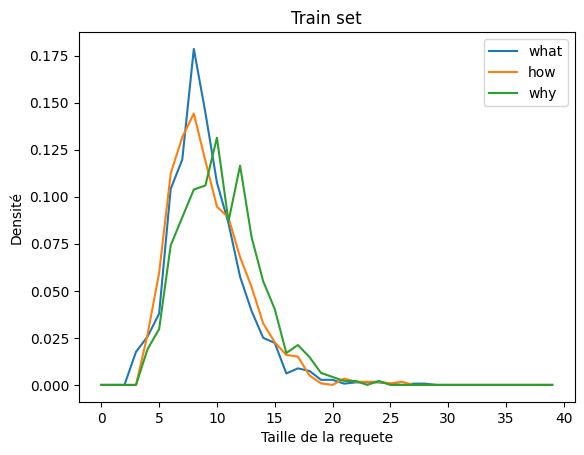

In [19]:
plt.title("Train set")
show_repartition(list(df_train['Question']))

#### Dev

what : 180 (43.2%)
how : 167 (40.0%)
why : 47 (11.3%)
autres : 23 (5.5%)


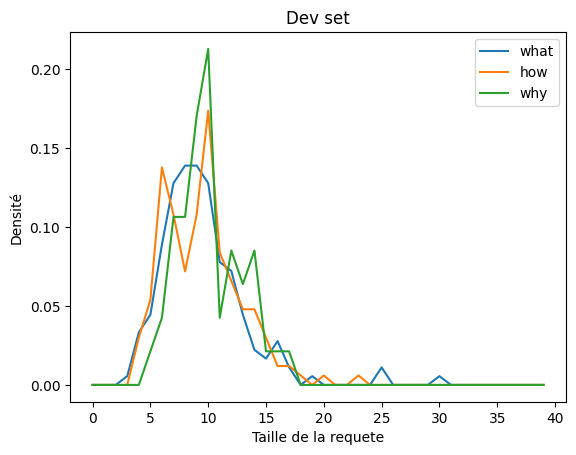

In [20]:
plt.title("Dev set")
show_repartition(list(df_dev['Question']))

#### Test

what : 167 (40.1%)
how : 166 (39.9%)
why : 60 (14.4%)
autres : 23 (5.5%)


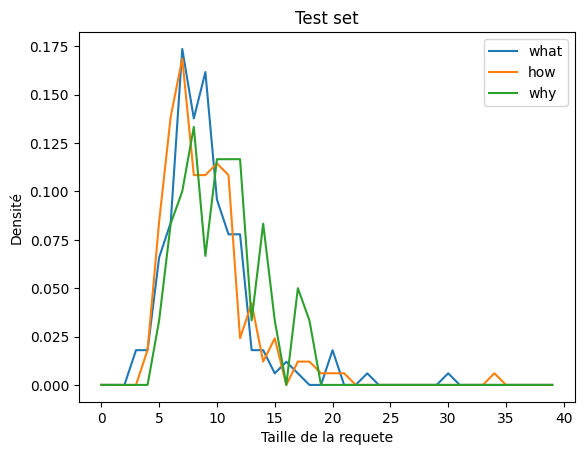

In [21]:
plt.title("Test set")
show_repartition(list(df_test['Question']))

#### Total

what : 1826 (43.8%)
how : 1526 (36.6%)
why : 579 (13.9%)
autres : 234 (5.6%)


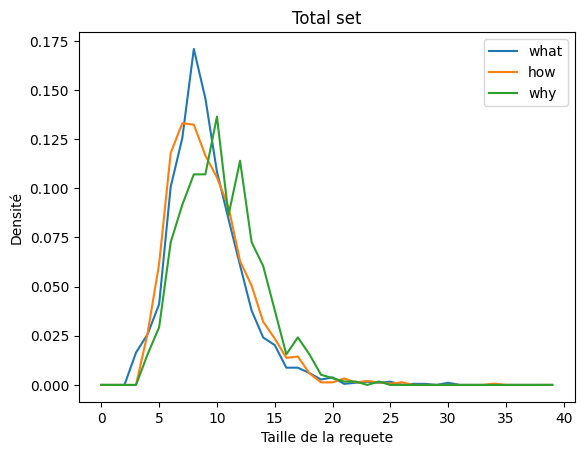

In [26]:
plt.title("Total set")
show_repartition(list(df_query['Question']))

### 2b) Documents
Calculons la taille moyenne d'un passage en mot

In [22]:
tailles_mean=np.mean([len(text.split()) for text in docs_df['text']])
tailles_mean

132.85691140441003

### 2c) Réponses

On calcule comme précédemment la densité de répartition de taille de réponses en fonction du prmier mot

In [23]:
max_taille_reponses=600

In [24]:
densites_reponses={prmier : np.zeros(max_taille_reponses+1) for prmier in prmiers_top3}
for prmier in prmiers_top3 :
    for query in queries_dict[prmier] :
        taille=0
        qid=(df_query[df_query['Question']==query]['QID']).iloc[0]
        documentID=(df_query[df_query['QID']==qid]['DocumentID']).iloc[0]
        relevant_passages=(df_query[df_query['QID']==qid]['RelevantPassages']).iloc[0]
        for passage in string_to_list(relevant_passages) :
            docno=str(documentID)+','+str(passage)
            texte=docs_df[docs_df['docno']==docno]['text'].iloc[0]
            taille+=len(texte.split())
            
        if taille<=max_taille_reponses :
            densites_reponses[prmier][taille]+=1
        
for prmier in prmiers_top3 :
    densites_reponses[prmier]=densites_reponses[prmier]/densites_reponses[prmier].sum()

Text(0, 0.5, 'Densité')

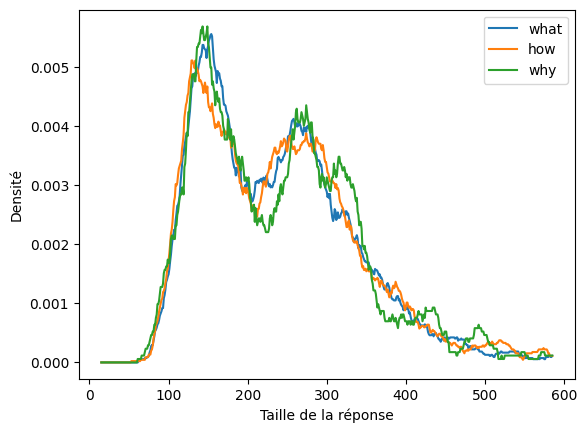

In [25]:
for prmier, densite in densites_reponses.items() :
    plot_smooth(densite,T=15,title=prmier)
plt.legend()
plt.xlabel("Taille de la réponse")
plt.ylabel("Densité")

C'est cohérent avec la taille moyenne d'un passage